In [1]:
%matplotlib inline
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [2]:
# Dashboard
band = np.linspace(380,780,1001);


In [3]:
class Cone():
    # Cone simulates the cone sensitivity of the human eye for each type Short, Medium, & Long
    
    def __init__(self,band,cone_type,load_data=True):
        self.band = band;
        self.cone_type = cone_type;
        if load_data == False:
            self.sensitivity = self.__gaussian();
        elif load_data == True:
            self.sensitivity = self.__load_sensitivity();
        else:
            print('Incorrect data type');
        self.response = np.zeros(self.band.shape);
        self.output = 0;
        
    def plot_sensitivity(self):
        colors = {'s':'tab:blue','m':'tab:green','l':'tab:red'};
        color = colors.get(self.cone_type.lower())
        return plt.plot(self.band,self.sensitivity,color);
    
    def plot_response(self):
        colors = {'s':'tab:blue','m':'tab:green','l':'tab:red'};
        color = colors.get(self.cone_type.lower())
        return plt.plot(self.band,self.response,color);
    
    def value(self,lam):
        return np.interp(lam,self.band,self.sensitivity);
        
    def __gaussian(self):
        cones = {'s': (445, 20), 'm': (545, 40), 'l': (570, 45)};
        mu,sigma = cones.get(self.cone_type.lower(),'Incorrect cone type specified. Please use S, M, or L')
        return np.exp(-0.5*((self.band - mu)/sigma)**2)
    
    def __load_sensitivity(self):
        import pandas as pd
        df = pd.read_csv('2deg_cone_response.csv',names=['wavelength','l','m','s']);
        out = np.interp(self.band,df['wavelength'],df[self.cone_type.lower()]);
        out[np.isnan(out)] = 0;
        return out
    
# s_cone = Cone(np.linspace(300,800,101),'S');
# m_cone = Cone(np.linspace(300,800,101),'M');
# l_cone = Cone(np.linspace(300,800,101),'L');

# s_cone.plot_sensitivity()
# m_cone.plot_sensitivity()
# l_cone.plot_sensitivity()

# plt.figure();
# s_cone.plot_response();

In [4]:
class Eye():
    # Class Eye creates the three standard cone responses as approximated by a gaussian distribution
    
    def __init__(self,band,load_data=True):
        self.band = band;
        self.s_cone = Cone(self.band,'S',load_data);
        self.m_cone = Cone(self.band,'M',load_data);
        self.l_cone = Cone(self.band,'L',load_data);
        self.s_response = np.zeros(self.band.shape)
        self.m_response = np.zeros(self.band.shape)
        self.l_response = np.zeros(self.band.shape)
        self.luminous_func = np.exp(-0.5*((self.band - 560)/45)**2)
        
    def plot_cones(self):
        self.s_cone.plot_sensitivity();
        self.m_cone.plot_sensitivity();
        self.l_cone.plot_sensitivity();
        
    def plot_response(self):
        self.s_cone.plot_response();
        self.m_cone.plot_response();
        self.l_cone.plot_response();
        
    def cone_values(self,tone):
        return self.s_cone.value(tone), self.m_cone.value(tone), self.l_cone.value(tone)
    
    def cone_sensitivities(self):
        return np.array([[self.s_cone.sensitivity],[self.m_cone.sensitivity],[self.l_cone.sensitivity]]);

    def response(self,Tone):
        # flatten all spectrum listed, currently only handles list of Tones
        # will need to check all bands are identical or interpolate between them
        band = Tone[0].band;
        light_in = np.zeros(band.shape);
        for spectrum in Tone:
            light_in += spectrum.amplitude

        # multiply whole spectrum by each cone sensitivity to get relative input
        self.s_cone.response = self.s_cone.sensitivity * light_in
        self.m_cone.response = self.m_cone.sensitivity * light_in
        self.l_cone.response = self.l_cone.sensitivity * light_in
        
        # integrate against each cone to get the total excitation for that cone
        self.s_cone.output = np.trapz(self.s_cone.response,band)
        self.m_cone.output = np.trapz(self.m_cone.response,band)
        self.l_cone.output = np.trapz(self.l_cone.response,band)
        self.cone_outputs  = np.array([self.s_cone.output, self.m_cone.output, self.l_cone.output]);
        
        return self.cone_outputs

# I think I need to scale my cone sensitivities to give them an integral of 1
# Right now each one collects different energy levels.
#
#
# eye1 = Eye(band);
# eye1.plot_cones();


In [5]:
class Spectrum():
    # Class Spectrum holds a base level class for holding spectra
    
    def __init__(self,band,amplitude=1):
        self.band = band;
        self.amplitude = amplitude*np.ones(self.band.shape)
        
    def plot(self):
        return plt.plot(self.band,self.amplitude,'k');

# white_light = Spectrum(band)
# white_light.plot()

In [6]:
class Tone(Spectrum):
    # Class Tone gives a specific type of spectrum, a tight gaussian distribution centered on an input wavelength
    
    def __init__(self,band,tone,amplitude=1,sigma=1):
        self.band = band;
        self.tone = tone;
        self.sigma = sigma;
        self.amplitude = amplitude*self.__gaussian();
        
    def __gaussian(self):
        mu = self.tone;
        sigma = self.sigma;
        return np.exp(-0.5*((self.band - mu)/sigma)**2)


# red_tone = Tone(band,700);
# red_tone.plot();

In [7]:
# class Spectra(list):
#     # Class Spectra can hold a variety of Light classes
#     # It also serves as a convenient way to handle the whole additive spectrum
    
#     def __init__(self):
#         self.band;
#         self.spectrum;
        
# s = list;
# print(s)
# s = [];
# print(s)

In [8]:
# # http://www.cvrl.org/database/text/sb_individual/sb10_individual.htm
# # 645.16nm (R), 526.32 (G), 444.44 (B)
# # alternatively
# # http://hyperphysics.phy-astr.gsu.edu/hbase/vision/colspa.html#c3
# # 700 nm (R), 546.1 nm (G), 435.8 nm (B)


# # Step 1: Generate primaries
# primaries = [];
# primaries.append(Tone(band,645.16));
# primaries.append(Tone(band,526.32));
# primaries.append(Tone(band,444.44));


# # Step 2: Generate pure tone
# pure_tone = []; # needs to be a list for now
# pure_tone.append(Tone(band,500));

# # Step 3: Generate eye
# eye1 = Eye(band);

# # Step 4: View both light sources
# output1 = eye1.response(primaries);
# output2 = eye1.response(pure_tone);


# # Step 5: Compare output signals
# print(output1)
# print(output2)

# # Step 6: 


# # Step 7: 

In [9]:
np.full(3,np.nan)

array([nan, nan, nan])

In [10]:
# s_cone = Cone(band,'S');
# m_cone = Cone(band,'M');
# l_cone = Cone(band,'L');

# f1 = 645.16; f2 = 526.32; f3 = 444.44;


# eye1 = Eye(band);
# t1 = np.interp(f1,band,eye1.luminous_func);
# t2 = np.interp(f2,band,eye1.luminous_func);
# t3 = np.interp(f3,band,eye1.luminous_func);

# pp = np.zeros((3,1,band.shape[0]));
# cc = np.zeros((3,3,band.shape[0]));
# ff = np.zeros((3,1,band.shape[0]));
# print(cc.shape)

# cs1 = s_cone.value(f1); cs2 = s_cone.value(f2); cs3 = s_cone.value(f3);
# cm1 = m_cone.value(f1); cm2 = m_cone.value(f2); cm3 = m_cone.value(f3);
# cl1 = l_cone.value(f1); cl2 = l_cone.value(f2); cl3 = l_cone.value(f3);
# mm = np.array([[cs1, cs2, cs3],[cm1, cm2, cm3],[cl1, cl2, cl3]])
# mminv = np.linalg.inv(mm);
# ff = np.array([[s_cone.sensitivity],[m_cone.sensitivity],[l_cone.sensitivity]]);

# for idx, val in enumerate(band):
#     pp[...,idx] = np.matmul(mminv, ff[...,idx])
    
# pp.shape
# rr = pp[0,0,:];
# gg = pp[1,0,:];
# bb = pp[2,0,:];
# plt.plot(rr,'tab:red');
# plt.plot(gg,'tab:green')
# plt.plot(bb,'tab:blue')

3 primaries given at: 700.0 nm, 546.1 nm, & 435.8 nm


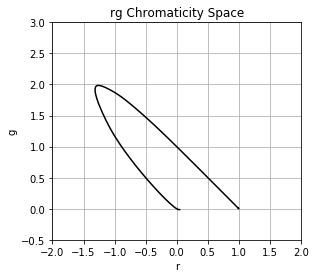

In [21]:
class ColorMatchingFunctions():    
    def __init__(self):
        self.band = np.full(101,np.nan);
        self.rgb = np.full(101,np.nan);
        self.xyz = np.full(101,np.nan);
           
    def match_functions(self,eye,primaries):
        self.eye = eye;
        self.band = self.eye.band;
        self.primaries = primaries; # list of tones
        
        # Get tone wavelengths
        t = np.full(len(primaries),np.nan)
        for idx, tone in enumerate(primaries):
            t[idx] = tone.tone
        print('{} primaries given at: {} nm, {} nm, & {} nm'.format(len(t),t[0],t[1],t[2]))
        
        self.cone_values = np.transpose(np.array([self.eye.cone_values(t[0]), \
                                                  self.eye.cone_values(t[1]), \
                                                  self.eye.cone_values(t[2])]))
        inverse_cone_values = np.linalg.inv(self.cone_values);
        
        rgb = np.zeros((3,1,self.band.shape[0]));
        
        temp_sensitivities = self.eye.cone_sensitivities()
        
        # Calculate matching functions
        for idx, val in enumerate(band):
            rgb[...,idx] = np.matmul(inverse_cone_values,temp_sensitivities[...,idx])
        
        # Normalize matching functions to have integral area = 1
        for idx, val in enumerate(primaries):
            rgb_area = np.trapz(rgb[idx,...],self.band);
            rgb[idx,...] = rgb[idx,...] / rgb_area
        
        self.rgb = rgb;
        
        return self.rgb
    
    def plot_rgb_cmfs(self):
        color = ('tab:red','tab:green','tab:blue');
        names = ['$\overline{r}(\lambda)$','$\overline{g}(\lambda)$','$\overline{b}(\lambda)$'];
        for n in range(len(self.primaries)):
            plt.plot(self.band,self.rgb[n,0,:],color=color[n],linestyle=':');
        plt.legend(names)
        plt.title('RGB Colormatching Functions');
        plt.xlabel('Wavlength (nm)')
        plt.ylabel('Amount (a.u.)')
        
    def plot_rgb_chrom(self):
        axs = plt.subplot(111);
        rgb_sum = np.sum(self.rgb,0);
        r_chrom = np.reshape(self.rgb[0,0,:] / rgb_sum,(1001,))
        g_chrom = np.reshape(self.rgb[1,0,:] / rgb_sum,(1001,))
        axs.plot(r_chrom,g_chrom,color='k')
        axs.grid(True); axs.set_xlabel('r'); axs.set_ylabel('g'); axs.set_title('rg Chromaticity Space');
        axs.axis('square'); axs.set_xlim([-2, 2]); axs.set_ylim([-0.5, 3.0]); 
        
        x = np.linspace(-2.0,2.0,1001);
        y = np.linspace(-0.5,3.0,1001);
        rv, gv = np.meshgrid(x,y);
        bv = 1.0 - rv - gv;
        

band = np.linspace(380,780,1001);
eye2 = Eye(band);
# eye1.plot_cones();
# plt.figure()
primaries = [];
# primaries.append(Tone(band,645.16,sigma=5));
# primaries.append(Tone(band,526.32,sigma=5));
# primaries.append(Tone(band,444.44,sigma=5));
primaries.append(Tone(band,700));
primaries.append(Tone(band,546.1));
primaries.append(Tone(band,435.8));

cmf = ColorMatchingFunctions();
cmf.match_functions(eye2,primaries);

# cmf.plot_rgb_cmfs();
plt.figure()
cmf.plot_rgb_chrom()



In [ ]:
rr = cmf.cmfs[0,0,:]
gg = cmf.cmfs[1,0,:]
bb = cmf.cmfs[2,0,:]
tt = rr + gg + bb

plt.plot(rr/tt)
plt.plot(gg/tt)
plt.plot(bb/tt)
# plt.plot(tt)
plt.figure()
plt.plot(rr/tt,gg/tt)
# R = rr / tt
# G = gg / tt
# B = bb / tt

In [ ]:
return
# for n in range(3):
#     plt.plot(band,tt[n,0,:],'k')
# cmf.plot_cmfs()
# eye1.plot_cones()
fig = plt.figure();
ax = fig.add_subplot(111)
ax.plot(band,(B))
ax.set_xlabel('Red')
ax.set_ylabel('Green')
# ax.set_zlabel('Blue')